# Figure 3

This notebook contains the functions used to construct Figure 3.

The figure contains 3 panels:

- a) Observed and expected profiles of mutations in colorectal and uterine POLE and MSI-H tumos as well as POLE and POLD-mutant bMMRD tumors.
- b) Decresed exonic mutation burden in POLE-mutant, MSI-H and bMMRD tumors.
- c) Representation of the increased efficency of MMR at exons and the decreased exonic mutation burden.

---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
from os import path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
from scipy.stats import chi2
from statsmodels.sandbox.stats.multicomp import multipletests as mlpt

from python_scripts.exon_centered_mutational_analysis import obs_exp_muts
from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params()

## Input

### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *clusters_file*: clusters of samples per tumor type
- *middle_exons_coords*: file with the coordinates of the middle exons

### Not included files

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- mutations_folder: base directory where the files with the mutations are located

### Other

- clusters_of_tumors: pairs of cluster and tumor to be analysed (for panel a)
- tumor_types_list: list of tumor types to be analysed (for panel b)

----

This notebook requires the output of the **signature_probability** and **gene_and_sample_analysis** notebook.

In [5]:
# Included
clusters_file = 'data/clusters.tsv'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'

# Not included
mutations_folder = 'non_provided_data/mutations/'

#Other
# Colorectal and uterine MSH-H and bMMRD POLE and POLD-mutant
clusters_of_tumors = [('crc', 'clusterB'), ('ucec', 'clusterA'), ('bMMRD', 'clusterA'), ('bMMRD', 'clusterB')]
tumor_types_list = ['bMMRD', 'blca', 'brca', 'crc', 'luad', 'lusc', 'skcm', 'ucec', 'eyelid']

## Sample level results

Per tumor type, cluster and sample we compute: the number of observed and expected mutations (for exons, introns, synonymous and non-synonymous mutations), the total number of mutations, the number of synonymous and non-synonymous mutations, number of bases in exons and introns, number of synonymous and non-synonymous variants, decrase over expected mutation in exons and non-synonymous (and the associated p_value).

Part of the analysis is described in the **Computing the decrease of exonic mutation burden** and **Test for negative selection of exonic mutations** sections.

Following the data from the *gene_and_sample_analysis* notebook, the expected exonic and intronic (or similarly synonymouys or non-synonimoys) can be computed as:

$$
EExonic = N_{muts} * \frac{v_{exons}}{v_{exons} + v_{introns}}, EIntronic = N_{muts} * \frac{v_{introns}}{v_{exons} + v_{introns}}
$$

Summing the observed and expected over all genes, the decrease of the exonic mutation burden can be computed (as the percentage of decrease of the observed number of mutations with respect to the expected).

In [6]:
def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """
    Likelihood ratio test
    """
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N  # probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob  # expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1)  # log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0)  # log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1)  # chi2 score to pvalue
    
    return my_p


In [7]:
sample_level_results = list()

clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)

for ttype in tumor_types_list:
    
    for my_cluster in set(clusters_df[clusters_df['ctype'] == ttype]['cluster']):
        
        #Load results for a given tumor type - cluster
        print(ttype, my_cluster)
    
        gene_dependent_results = path.join('results', "%s_%s_gene_dependent_results.txt" % (ttype, my_cluster))  # Output from other notebook
        sample_dependent_results = path.join('results', "%s_%s_sample_dependent_results.txt" % (ttype, my_cluster))  # Output from other notebook
                
        genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
        samplelvl_results_df = pd.read_csv(sample_dependent_results, sep='\t')

        my_genes =  genelvl_results_df['ensembl'].tolist()
        print(len(my_genes))
        samples_list = list(set(samplelvl_results_df['sample'].tolist()))

        products_sum_df = genelvl_results_df
        
        #Iterate samples in order to get the reduced exonic mutation burder per sample
        for my_sample in samples_list:
            sub_samplelvl_results_df = samplelvl_results_df[samplelvl_results_df['sample'] == my_sample]

            sub_samplelvl_results_df.columns = ['ensembl', 'obs_exon_muts', 'obs_intron_muts',
                                                'obs_syn_muts', 'obs_nonsyn_muts', 'sample']

            merged_sub_results = pd.merge(sub_samplelvl_results_df, products_sum_df, on='ensembl')

            # Exonic and intronic mutations
            merged_sub_results['exons_prob'] = merged_sub_results['exons_products_sum']/(merged_sub_results['exons_products_sum']+merged_sub_results['introns_products_sum'])
            merged_sub_results['introns_prob'] = merged_sub_results['introns_products_sum']/(merged_sub_results['exons_products_sum']+merged_sub_results['introns_products_sum'])
            merged_sub_results['total_muts'] = merged_sub_results['obs_exon_muts']+merged_sub_results['obs_intron_muts']

            merged_sub_results['exp_exon_muts'] = merged_sub_results['total_muts']*merged_sub_results['exons_prob']
            merged_sub_results['exp_intron_muts'] = merged_sub_results['total_muts']*merged_sub_results['introns_prob']

            n_obs_muts = merged_sub_results['obs_exon_muts'].sum()
            n_exp_muts = merged_sub_results['exp_exon_muts'].sum()

            n_intron_muts = merged_sub_results['obs_intron_muts'].sum()
            n_exp_intron_muts = merged_sub_results['exp_intron_muts'].sum()
            
            try:
                exons_decrease_over_expected = -(n_exp_muts-n_obs_muts)/n_exp_muts*100 
                
            except:
                exons_decrease_over_expected = np.nan

            total_muts = (n_obs_muts+n_intron_muts)
            
            exp_exon_prob = n_exp_muts/(n_obs_muts+n_intron_muts)
            
            my_exin_p = compute_pval(n_obs_muts, n_intron_muts, exp_exon_prob)

            # Synonimoys and nonsyn mutations            
            n_syn_muts = merged_sub_results['obs_syn_muts'].sum()
            n_nonsyn_muts = merged_sub_results['obs_nonsyn_muts'].sum()
            
            total_constype_muts = n_syn_muts + n_nonsyn_muts
            
            merged_sub_results['syn_prob'] = merged_sub_results['syn_products_sum']/(merged_sub_results['syn_products_sum']+merged_sub_results['nonsyn_products_sum'])
            merged_sub_results['nonsyn_prob'] = merged_sub_results['nonsyn_products_sum']/(merged_sub_results['syn_products_sum']+merged_sub_results['nonsyn_products_sum'])
            merged_sub_results['total_cons_muts'] = merged_sub_results['obs_syn_muts']+merged_sub_results['obs_nonsyn_muts']

            merged_sub_results['exp_syn_muts'] = merged_sub_results['total_cons_muts']*merged_sub_results['syn_prob']
            merged_sub_results['exp_nonsyn_muts'] = merged_sub_results['total_cons_muts']*merged_sub_results['nonsyn_prob']

            n_exp_syn_muts = merged_sub_results['exp_syn_muts'].sum()
            n_exp_nonsyn_muts = merged_sub_results['exp_nonsyn_muts'].sum()
            
            try:
                nonsyn_decrease_over_expected = -(n_exp_nonsyn_muts-n_nonsyn_muts)/n_exp_nonsyn_muts*100 

            except:
                nonsyn_decrease_over_expected = np.nan
                
                
            try:
                exp_syn_prob = n_exp_syn_muts/(n_exp_syn_muts+n_exp_nonsyn_muts)
                my_synnonsyn_p = compute_pval(n_syn_muts, n_nonsyn_muts, exp_syn_prob)
            
            except:
                exp_syn_prob = np.nan
                my_synnonsyn_p = np.nan
            

            # Number of sites            
            exons_bp = merged_sub_results['exons_bp'].sum()
            introns_bp = merged_sub_results['introns_bp'].sum()
            syn_vars = merged_sub_results['n_synonimous_variants'].sum()
            nonsyn_vars = merged_sub_results['n_non_synonimous_variants'].sum()
        
            my_row = [ttype, my_cluster, my_sample, n_obs_muts, n_exp_muts, n_intron_muts, n_exp_intron_muts,
                      total_muts, n_syn_muts, n_exp_syn_muts, n_nonsyn_muts, n_exp_nonsyn_muts, total_constype_muts,
                      exons_bp, introns_bp, syn_vars, nonsyn_vars, exons_decrease_over_expected,
                      nonsyn_decrease_over_expected, my_exin_p, my_synnonsyn_p]
            
            
            sample_level_results.append(my_row)

results_per_sample_df = pd.DataFrame(sample_level_results)
results_per_sample_df.columns = ['tumor_type', 'cluster', 'sample', 'obs_exon_muts',
                                 'exp_exon_muts', 'obs_intron_muts', 'exp_intron_muts',
                                 'total_muts', 'n_syn_muts', 'n_exp_syn_muts','n_nonsyn_muts',
                                 'n_exp_nonsyn_muts', 'total_constype_muts', 'exons_bp',
                                 'introns_bp', 'syn_variants', 'nonsyn_variants',
                                 'exons_decrease_over_expected',
                                 'nonsyn_decrease_over_expected', 'exon_intron_p',
                                 'syn_nonsyn_p']

results_per_sample_df.to_csv(path.join('results', "results_per_sample_df.csv"), sep="\t", header=True, index=False)

bMMRD clusterA
10292
bMMRD clusterB
10292
blca clusterA
10288
blca clusterB
10288
brca clusterD
10288
brca clusterB
10288
brca clusterC
10288
brca clusterA


/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: divide by zero encountered in log
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in multiply
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:76: RuntimeWarning: invalid value encountered in double_scalars
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:83: RuntimeWarning: invalid value encountered in double_scalars
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in long_scalars


10288
brca clusterE
10288
crc clusterA
10289
crc clusterB
10289
crc clusterC
10289
luad clusterD
10275
luad clusterB
10275
luad clusterC
10275
luad clusterF
10275
luad clusterA
10275
lusc clusterA
10285
lusc clusterB
10285
skcm clusterA
10294
skcm clusterB
10294
ucec clusterD
10283
ucec clusterB
10283
ucec clusterC
10283
ucec clusterA
10283
ucec clusterE
10283
eyelid clusterA
10294


### Panel a)

Decreased exonic mutation burden in POLE-mutant (colorectal and uterine), MSI-H and bMMRD tumors.
Dots represent individual samples. Purple ones are for tumors with a significant decreased exonic mutation burden, blue ones for tumors with non-significant decrease in exonic mutation burden and gray for tumors with no decreased mutation burden.
Red lines reprsent the median value of the group.

In [8]:
clusters_df = pd.read_csv(clusters_file, sep='\t', low_memory=False)
sub_clusters_df = clusters_df[['sample_id', 'annotation']]
sub_clusters_df.columns = ['sample', 'annotation']
results_per_sample_df = pd.read_csv(path.join('results', "results_per_sample_df.csv"), sep="\t", header=0)

MSIH_samples = ['TCG-AA-3518-01A', 'TCGA-AA-A01R-01A', 'TCGA-A6-6781-01A',
                'TCGA-AZ-6601-01A', 'TCGA-AA-3516-01A', 'TCGA-AD-6964-01A',
                'TCGA-AP-A051-01A', 'TCGA-AX-A0J1-01A', 'TCGA-BS-A0TE-01A',
                'TCGA-AP-A0LD-01A', 'TCGA-AP-A0LE-01A', 'TCGA-B5-A11H-01A',
                'TCGA-A5-A0GA-01A', 'TCGA-A5-A0GG-01A', 'TCGA-A5-A0G9-01A',
                'TCGA-AX-A05S-01A']

POLE_mutated_samples = ['TCGA-BS-A0TC-01A','TCGA-AA-3555-01A','TCGA-EI-6917-01A',
                        'TCGA-CA-6717-01A','TCGA-AA-3977-01A','TCGA-A6-6141-01A',
                        'TCGA-CA-6718-01A']

bMMRD_samples = clusters_df[clusters_df['ctype'] == 'bMMRD']['sample_id'].tolist()

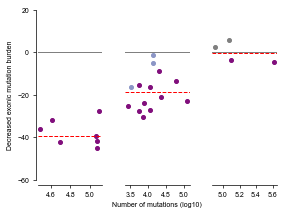

In [9]:
new_labels = ['−20%', '0%', '20%', '40%', '60%']

fig = plt.figure(figsize=(4, 3))
NROW=1
NCOL=3
ax=[]
for row in range(0, NROW):
    for col in range(0, NCOL):
        ax.append(plt.subplot2grid((NROW, NCOL), (row, col)))
acnt=0        

count=1
for my_samples in [POLE_mutated_samples, MSIH_samples, bMMRD_samples]:
    

    merged_df = pd.merge(results_per_sample_df, sub_clusters_df, on='sample')
    merged_df = merged_df[merged_df['total_muts'] > 1500]

    merged_df = merged_df[merged_df['sample'].isin(my_samples)]

    if len(merged_df) > 0:

        # adjust the p-value for multiple testing using BH approach
        merged_df['exon_intron_p_adj']= mlpt(merged_df['exon_intron_p'], method='fdr_bh')[1]

        my_median = np.median(merged_df['exons_decrease_over_expected'])

        significant_samples_decreased = merged_df[(merged_df['exons_decrease_over_expected'] < 0)
                                                  & (merged_df['exon_intron_p_adj'] < 0.1)][['total_muts', 'exons_decrease_over_expected']]

        non_significant_samples_decreased = merged_df[(merged_df['exons_decrease_over_expected'] < 0)
                                                  & (merged_df['exon_intron_p_adj'] >= 0.1)][['total_muts', 'exons_decrease_over_expected']]

        significant_samples_increased = merged_df[(merged_df['exons_decrease_over_expected'] > 0)
                                                  & (merged_df['exon_intron_p_adj'] < 0.1)][['total_muts', 'exons_decrease_over_expected']]

        non_significant_samples_increased = merged_df[(merged_df['exons_decrease_over_expected'] > 0)
                                                  & (merged_df['exon_intron_p_adj'] >= 0.1)][['total_muts', 'exons_decrease_over_expected']]                                 

        my_grouped_samples = dict()
        my_grouped_samples['exonic_significant_decrease'] = significant_samples_decreased
        my_grouped_samples['exonic_non_significant_decrease'] = non_significant_samples_decreased
        my_grouped_samples['exonic_significant_increase'] = significant_samples_increased
        my_grouped_samples['exonic_non_significant_increase'] = non_significant_samples_increased

        my_colors_list = ['#810f7c', '#8c96c6', 'gray', 'gray']

        i = 0

        # Plot
        
        ax[acnt].margins(0.05) # Optional, just adds 5% padding to the autoscaling
        ax[acnt].set_facecolor('none')


        for my_key in ['exonic_significant_decrease', 'exonic_non_significant_decrease',
                       'exonic_significant_increase', 'exonic_non_significant_increase']:

            group = my_grouped_samples[my_key]

            ax[acnt].plot(np.log10(group.total_muts), group.exons_decrease_over_expected,
                    marker='.', linestyle='', label=my_key, c=my_colors_list[i], ms = 8, )

            i +=1

        ax[acnt].set_ylim(-60, 20)
        ax[acnt].axhline(y=my_median, ls='--', c='red', alpha=1, linewidth=1)
        ax[acnt].axhline(y=0, c='gray', linewidth=1)

        #ax[acnt].grid(linestyle='--', linewidth='0.1', color='black', alpha=0.5)
        
        if acnt==1:
            ax[acnt].set_xlabel('Number of mutations (log10)')
        
        if acnt == 0:
            ax[acnt].tick_params(axis='x', direction='out')
            ax[acnt].tick_params(axis='y', direction='out')
                # show the left spline
            for axis in ['right', 'top']:
                ax[acnt].spines[axis].set_visible(False)

            for axis in ['bottom', 'left']:
                ax[acnt].spines[axis].set_position(('axes', -0.03))

            ax[acnt].yaxis.set_ticks_position('left')
            ax[acnt].xaxis.set_ticks_position('bottom')
            ax[acnt].set_ylabel('Decreased exonic mutation burden')
            
        else:
            ax[acnt].tick_params(axis='x', direction='out')
            ax[acnt].tick_params(axis='y', direction='out')
                # show the left spline
            for axis in ['right', 'top', 'left']:
                ax[acnt].spines[axis].set_visible(False)
                ax[acnt].get_yaxis().set_ticks([])

            for axis in ['left', 'bottom']:
                ax[acnt].spines[axis].set_position(('axes', -0.03))

            ax[acnt].yaxis.set_ticks_position('left')
            ax[acnt].xaxis.set_ticks_position('bottom')
       
        ax[acnt].xaxis.major.locator.set_params(nbins=5)
        ax[acnt].yaxis.major.locator.set_params(nbins=5)
        acnt+=1
      

    
plt.tight_layout()

plt.savefig(path.join('figures', "figure3A.svg"))
count+=1

plt.show()

## Exons centered analysis

Following the method described in the **Exon-centered and intron-centered mutational analyses** section, for each exonic position around the center, we computed the observed and expected number of mutations.

The code is the same as for figure 2a.

In [10]:
middle_distance_threshold = 1000

for tumor_type, cluster_id in clusters_of_tumors:
    print(tumor_type, '\t', cluster_id)
    mutations_file = mutations_folder + tumor_type + '.bed.gz'
    exons_centered_results = obs_exp_muts(mutations_file, clusters_file, middle_exons_coords, path.join('results', 'signatures.txt'), tumor_type, cluster_id, middle_distance_threshold)
    exons_centered_results.to_csv(path.join('results', "%s_%s_exons_centered.tsv" % (tumor_type, cluster_id)), 
                                  sep="\t", header=True, index=False)

crc 	 clusterB
ucec 	 clusterA
bMMRD 	 clusterA
bMMRD 	 clusterB


### Panel b)

Exon centered 2001-nucleotide wide observed and expected profiles of mutations in 6 colorectal and 10 uterine MSI-H tumores and 2 POLE-mutanat and 2 POLD-mutant bMMRD tumors

/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:17: RankWarning: The fit may be poorly conditioned
/home/ireyes/anaconda3/envs/intronexon/lib/python3.6/site-packages/ipykernel/__main__.py:24: RankWarning: The fit may be poorly conditioned


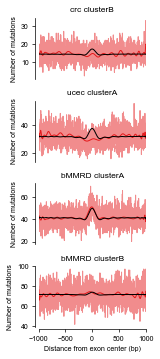

In [11]:
fig = plt.figure(figsize=(2.25, 5))

plot_columns = 1
plot_rows = len(clusters_of_tumors)//plot_columns
if len(clusters_of_tumors) % plot_columns != 0:
    plot_rows += 1

for index, val in enumerate(clusters_of_tumors):
    tumor_type, cluster_id = val

    my_complete_results = pd.read_csv(path.join('results', "%s_%s_exons_centered.tsv" % (tumor_type, cluster_id)), 
                                      sep="\t")

    ax = fig.add_subplot(plot_rows, plot_columns, index+1)

    # Observed
    coefs = poly.polyfit(my_complete_results['position'], my_complete_results['muts_count'], 50)
    ffit = poly.polyval(my_complete_results['position'], coefs)

    ax.plot(my_complete_results['position'], my_complete_results['muts_count'], '#e41a1c', alpha=0.5, linewidth=1)
    ax.plot(my_complete_results['position'], ffit, '#e41a1c', linewidth=1)

    # Expected
    coefs2 = poly.polyfit(my_complete_results['position'], my_complete_results['expected_muts'], 50)
    ffit2 = poly.polyval(my_complete_results['position'], coefs2)
    ax.plot(my_complete_results['position'], ffit2, 'black', linewidth=1)

    ax.set_facecolor('none')

    # show the left spline
    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    # add gap between x- and y-axis
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.03))

    ax.yaxis.major.locator.set_params(nbins=4)
    ax.set_xlim(-1000, 1000)
    ax.set_ylabel('Number of mutations', fontsize=7)
    
    if tumor_type == 'bMMRD' and cluster_id == 'clusterB':
        ax.set_xlabel('Distance from exon center (bp)')    
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')
        
    else:
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_ticks([])
        
    ax.set_title('%s %s' % (tumor_type, cluster_id))

plt.tight_layout()
plt.savefig(path.join('figures', "figure3B.svg"))
plt.show()

### Panel c)

Panel c) is a representation and does not come directly from computed data.